In [1]:
from Model.Energy import GaussianEnergy
from Model.Proposal import GaussianProposal
from Data import get_dataloader_from_data
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from Model.Trainer import SNLTrainer
from Model.Energy import MaxMinTruncation

/opt/miniconda3/envs/lime_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training data 

In [2]:
target_distribution = torch.distributions.Normal(torch.tensor([0,0], dtype=torch.float32) , torch.tensor([4,2], dtype=torch.float32))


In [11]:
sample_target_cartesian = target_distribution.sample((100000,))
# Select only the samples that are in the first quadrant
sample_target_cartesian = sample_target_cartesian[sample_target_cartesian[:,0] > -1 ]
sample_target_cartesian = sample_target_cartesian[:20000]




dataset_total = TensorDataset(sample_target_cartesian, )
data_train, data_val, data_test = torch.utils.data.random_split(dataset_total, [10000, 5000, 5000])
dataloader_train = DataLoader(data_train, batch_size=100, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=100, shuffle=False)

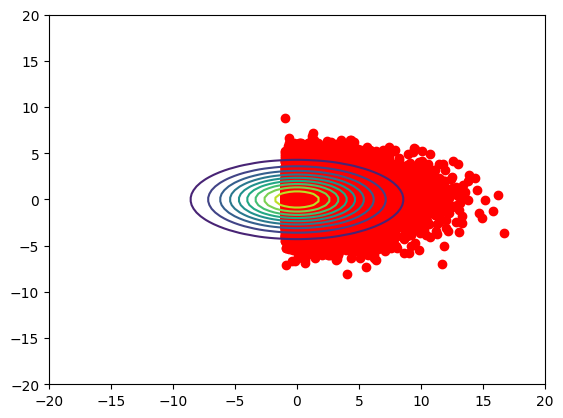

In [12]:


fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = target_distribution.log_prob(torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)).sum(-1).exp().numpy()

ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_target_cartesian[...,0], sample_target_cartesian[...,1], color='r')

# Proposal

In [13]:
proposal_distribution = GaussianProposal(torch.Size([2,]), torch.tensor([0,0], dtype=torch.float32), torch.tensor([10,10], dtype=torch.float32))

Init Standard Gaussian...


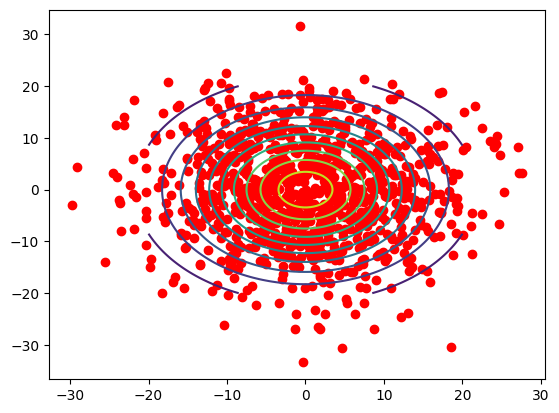

In [14]:
sample_proposal = proposal_distribution.sample(1000,)

fig = plt.figure()
ax = fig.add_subplot(111)
# Add gaussian distribution as contours

x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
input_grid = torch.tensor([X,Y], dtype=torch.float32).permute(1,2,0)
Z = proposal_distribution.log_prob(input_grid.flatten(0,1)).exp().numpy().reshape(X.shape)
ax.contour(X, Y, Z, levels=10)


# Add points
ax.scatter(sample_proposal[...,0], sample_proposal[...,1], color='r')

# Energy

In [15]:
energy = GaussianEnergy(dim=2, learn_mu=True, learn_sigma=True)
energy.set_truncator(MaxMinTruncation(min = torch.tensor([-1,-20], dtype=torch.float32), max= torch.tensor([20,20], dtype=torch.float32)))

/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/Truncation/abstract_truncation.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.max = torch.tensor(max, dtype=torch.float32)
/Users/hhjs/Documents/Projects/SNL_directional/Model/Energy/Truncation/abstract_truncation.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.min = torch.tensor(min, dtype=torch.float32)


In [16]:
print(energy(x=sample_target_cartesian))
print(energy(x=sample_proposal))

tensor([ 2.2644, 15.2347,  0.3751,  ..., 13.6636,  6.8273,  8.8712],
       grad_fn=<WhereBackward0>)
tensor([7.3895e+01, 1.4467e+02, 1.0000e+08, 5.2911e+01, 3.4692e+01, 1.1133e+02,
        8.1307e+01, 1.0000e+08, 1.0000e+08, 9.2103e+01, 1.0000e+08, 4.4864e+01,
        4.1104e+01, 1.0000e+08, 1.0000e+08, 1.3621e+02, 1.0000e+08, 1.0000e+08,
        1.0000e+08, 1.3032e+02, 1.0000e+08, 4.1070e+01, 1.0000e+08, 1.1832e+02,
        1.0338e+02, 1.2991e+02, 1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08,
        8.9039e+01, 1.0000e+08, 1.0000e+08, 1.7471e+01, 1.0000e+08, 4.0705e+01,
        1.0000e+08, 3.1891e+02, 6.1395e+01, 1.0000e+08, 1.0000e+08, 1.0000e+08,
        1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08,
        1.0000e+08, 1.2485e+02, 9.7355e+01, 1.7045e+01, 1.4744e+01, 1.0000e+08,
        1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08, 1.0000e+08, 1.2277e+02,
        1.0000e+08, 1.0000e+08, 1.0488e+01, 8.2131e+01, 1.0000e+08, 1.0000e+08,
        1.6677e+01

# Trainer :


In [17]:
trainer = SNLTrainer(energy=energy, proposal=proposal_distribution, dataloader=dataloader_train, val_dataloader=dataloader_val , n_sample_train=1000, n_sample_test=1000, lr=0.01, )

param/explicit_bias,▁▁██████████████████████████████████████
param/log_sigma_0,▁▁▇▇▇███████████████████████████████████
param/log_sigma_1,▁▁██▇█████████████████▇▇▇██▇██▇██▇▇█████
param/mu_0,▂▂█▇▅▄▃▂▂▁▂▂▁▁▂▂▁▁▁▂▁▁▁▁▂▂▁▂▂▂▂▁▁▁▁▂▂▂▁▁
param/mu_1,▆▆▄▁▅▃▄▇▃▄▅▄▅▅▅▅▄▅▄▃▄▁▇▅█▇▇▄▄▄▆▆▃▄▂█▆▃▆▅
param/sigma_0,▁▁▆▇▇▇▇█▇█▇▇█▇████████▇▇▇██████████▇█▇██
param/sigma_1,▁▁▇▇▇██████▇███▇▇▇██▇█▇▇▇█▇▇▇█▇██▇▇▇█▇▇▇
train/log_likelihood_lower_bound (SNL),▂▁██▇█▇████████▇▇█▇█████▇▇██▇█████▇█▇███
train/log_likelihood_upper_bound,▁▁██▇█████▇█████▇█▇█████▇███▇█████▇█████
train/loss,▇█▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁
train/loss_proposal,▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇


In [ ]:
trainer.train(n_iter=200_000, n_iter_pretrain=1000,)

HERE
torch.Size([1000, 2])
torch.Size([818, 2])
HERE
torch.Size([1000, 2])
torch.Size([851, 2])
HERE
torch.Size([1000, 2])
torch.Size([742, 2])
HERE
torch.Size([1000, 2])
torch.Size([752, 2])
HERE
torch.Size([1000, 2])
torch.Size([739, 2])
HERE
torch.Size([1000, 2])
torch.Size([711, 2])
HERE
torch.Size([1000, 2])
torch.Size([735, 2])
HERE
torch.Size([1000, 2])
torch.Size([753, 2])
HERE
torch.Size([1000, 2])
torch.Size([749, 2])
HERE
torch.Size([1000, 2])
torch.Size([735, 2])
HERE
torch.Size([1000, 2])
torch.Size([735, 2])
HERE
torch.Size([1000, 2])
torch.Size([752, 2])
HERE
torch.Size([1000, 2])
torch.Size([742, 2])
HERE
torch.Size([1000, 2])
torch.Size([736, 2])
HERE
torch.Size([1000, 2])
torch.Size([752, 2])
HERE
torch.Size([1000, 2])
torch.Size([733, 2])
HERE
torch.Size([1000, 2])
torch.Size([723, 2])
HERE
torch.Size([1000, 2])
torch.Size([727, 2])
HERE
torch.Size([1000, 2])
torch.Size([753, 2])
HERE
torch.Size([1000, 2])
torch.Size([745, 2])
HERE
torch.Size([1000, 2])
torch.Size([7